# SOC LEAFs Forest and Grassland supporting calculations
This notebook documents the generation of forest and grassland base data needed to run RothC model and serves as a complement to [SOC_LEAFs_Baseline](../documentation/SOC_LEAFs_Baseline.ipynb) notebook.

Notes from IPCC 2003
- Litter to carbon: To convert to dry matter mass of litter to carbon, multiply the mass by a default value of 0.370 (Smith and Heath, 2002), not the carbon fraction used for biomass.
- Transition time: The transition from Ci to Cj is assumed to take place over a transition period of T years (default = 20 years).

## Step 1 - Data Preparation
### 1) Litter
As land use has already been determined, the next step is to estimate litter production annually. Litter production is estimated in two periods: a) growing and b) mature. [IPCC 2003](https://www.ipcc-nggip.iges.or.jp/public/gpglulucf/gpglulucf_files/Chp3/Chp3_2_Forest_Land.pdf) provides residue production $\small (RES_{maturity})$ on maturity on Table 3.2.1, which is used here, as well as time to reach maturity (transition period or TP) for Broadleaf and Needleleaf forest in different thermal zones. Litter production during the growing period is assumed to grow linearly from 0 till TP, and thus can be calculated as:
$$ I_{t} = \min(RES_{maturity}, RES_{maturity}/TP\cdot(TP-t)) $$

Where $t$ is the age of the forest.

Litter production values from table 3.2.1 has been summarized in [forest_residues_IPCC](../data/forest/forest_residues_IPCC.xlsx) excel spreadsheet.

#### 1.2) Forest age
To estimate forest age in accordance with Soil Grids SOC baseline, the [Global Forest Age Dataset (GFAD)](https://research.wur.nl/en/datasets/the-global-forest-age-dataset-and-its-uncertainties-gfadv11) v1.1 is used. This dataset assigns the fraction of each grid cell to an age band (1-10, 11-20, ... 141-150) for 4 different forest types: Broadleaf Deciduous, Broadleaf Evergreen, Needleleaf Deciduous, and Needleleaf Evergreen.

Loading the data...

In [26]:
# modules
import xarray as xr
import numpy as np
import rioxarray
import rasterio
from rasterio.enums import Resampling

# data
fa_fp = "../data/forest/GFAD_V1-1/GFAD_V1-1.nc"

Examining...

In [2]:
ds = xr.open_dataset(fa_fp, chunks={"lat": 180, "lon": 180})
print(ds)                 # dims, coords, attributes
print(ds.data_vars)       # list variables
print(ds.coords)          # look for 'lat'/'lon' and an age dimension like 'age' or 'age_class'

<xarray.Dataset> Size: 126MB
Dimensions:    (Class: 15, PFT: 4, lat: 360, lon: 720)
Coordinates:
  * Class      (Class) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * PFT        (PFT) int32 16B 1 2 3 4
  * lat        (lat) float64 3kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon        (lon) float64 6kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Data variables:
    age        (Class, PFT, lat, lon) float64 124MB dask.array<chunksize=(15, 4, 180, 180), meta=np.ndarray>
    adminunit  (lat, lon) float64 2MB dask.array<chunksize=(180, 180), meta=np.ndarray>
Attributes: (12/32)
    institution:         NASA and Laboratoire des Science du Climat et de Env...
    institute_id:        NASA/LSCE
    data_id:             forest age
    contact:             Ben Poulter, benjamin.poulter@nasa.gov
    title:               GEOCARBON_ForestAge_LSCE_v1
    reference:           In preparation
    ...                  ...
    Class 10:            Age 91-100
    Class 11:            Age 101-110

Accessing Needleleaf Evergreen data, age band 1-10 years...

In [11]:
# NEEV (PFT=1), Class 1  → returns a 2D (lat, lon) DataArray
neev_class1 = ds["age"].sel(PFT=1, Class=1)
neev_class1

<xarray.DataArray 'age' (lat: 360, lon: 720)> Size: 2MB
dask.array<getitem, shape=(360, 720), dtype=float64, chunksize=(180, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
    PFT      int32 4B 1
    Class    int32 4B 1
Attributes:
    units:      fraction
    long_name:  PFT age classes

Plotting

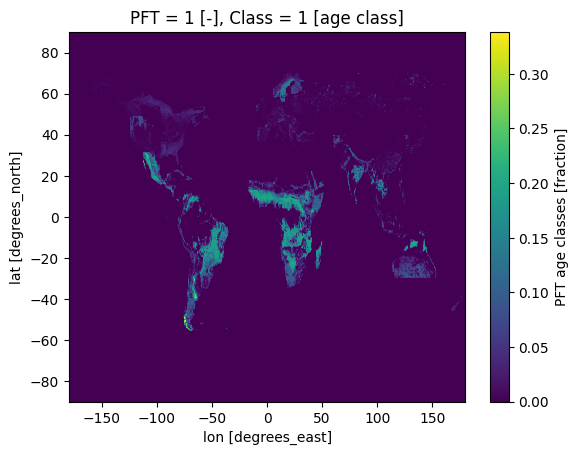

In [12]:
neev_class1.plot()

Now, calculating a weighted average age per forest type.

In [32]:
# 1) Pick midpoints for your 15 bins.
# If you want 5, 15, ..., 145 exactly (as in your example):
mid_age  = np.arange(5, 150, 10, dtype="float32")     # length 15
low_age  = np.arange(1, 150, 10, dtype="float32")     # length 15
high_age = np.arange(10, 150, 10, dtype="float32")     # length 15

# 2) Make a DataArray aligned to the Class dimension
age_mid = xr.DataArray(
    mid_age,
    dims=["Class"],
    coords={"Class": ds["Class"]}   # ensures same indexing as your dataset
)

# 3) Compute weighted mean age per PFT,lat,lon
#    (normalize in case the class probabilities don’t sum exactly to 1)
weights = ds["age"]                 # dims: Class, PFT, lat, lon
w_sum = weights.sum(dim="Class")
mean_age = (weights * age_mid).sum(dim="Class") / w_sum.where(w_sum > 0)

# Result dims: PFT, lat, lon  (one mean age map per PFT)
mean_age


<xarray.DataArray (PFT: 4, lat: 360, lon: 720)> Size: 8MB
dask.array<truediv, shape=(4, 360, 720), dtype=float64, chunksize=(4, 180, 180), chunktype=numpy.ndarray>
Coordinates:
  * PFT      (PFT) int32 16B 1 2 3 4
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

Plotting the results for Needleleaf Evergreeen

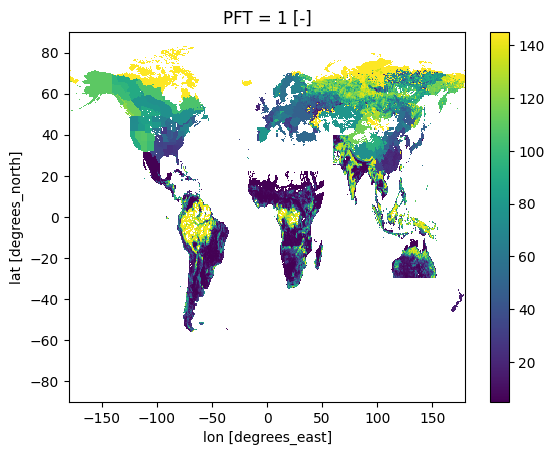

In [10]:
# Example: NEEV = PFT code 1
neev_mean = mean_age.sel(PFT=1)            # 2D (lat, lon)
neev_mean.plot()

Now that each average age has been calculated, this can be use to estimate the age of each of the 16 land uses available. This are stored in UHTH-aligned GeoTIFF for easier computing.

First, opening the grid

In [28]:
# Loading uhth map
uhth_fp = "../data/world_maps/soc_uht_map.tif"
master = rioxarray.open_rasterio(uhth_fp)
master_grid = master.isel(band=0)

Massaging the age data...

In [35]:
# ensuring dims and order
mean_age_2tif = mean_age.transpose("PFT", "lat", "lon")

# rioxarray prefers ascending y/x—keep lat/lon ascending
mean_age_2tif = mean_age_2tif.sortby(["lat", "lon"])

# Rename spatial dims to x/y so rioxarray can’t miss them
mean_age_2tif = mean_age_2tif.rename({"lon": "x", "lat": "y"})

# Assigning a CRS. 
mean_age_2tif = mean_age_2tif.rio.write_crs("EPSG:4326")

# Explicitly set spatial dims (now literally 'x', 'y')
mean_age_2tif = mean_age_2tif.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=False)

# --- Rename PFT -> band to write a multi-band GeoTIFF
da_mb = mean_age_2tif.rename(PFT="band")

# --- Reproject & snap to the master grid exactly
da_mb_matched = da_mb.rio.reproject_match(master_grid, resampling=Resampling.bilinear)

# Assign no data
da_mb_matched = da_mb_matched.rio.write_nodata(-9999.0)

Now saving

In [36]:
da_mb_matched.rio.to_raster(
        "../data/forest/forest_average_age.tif",
        dtype="float32",
        compress="lzw",
        predictor=3,   # good for float data with LZW
        tiled=True,
        num_threads="ALL_CPUS"
)

Adding metadata